In [1]:
#Import all the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
import warnings
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.colors import TwoSlopeNorm
from sklearn.preprocessing import StandardScaler

# Functions

In [2]:
def Y(energy, f_mode):
    Y = torch.zeros((4, 1))

    #Convert Energy to PeV
    xe = .5 + 20 * (torch.log(energy) - log_01) / (log_10 - log_01)
    xe2 = xe * xe

    #Evaluate Y for given energy and mode
    for i in range(4):
        if f_mode == "mg0":
            Y[i] = torch.exp(PXmg_p[i, 0, 0]) + torch.exp(PXmg_p[i ,0, 1] * torch.pow(xe, PXmg_p[i, 0, 2]))

        elif f_mode == "mg2":
            Y[i] = PXmg_p[i, 2, 0] + PXmg_p[i, 2, 1] * xe + PXmg_p[i, 2, 2] * xe2

        elif f_mode == "eg0":
            Y[i] = PXeg_p[i, 0, 0] * torch.exp(PXeg_p[i, 0, 1] * torch.pow(xe, PXeg_p[i, 0, 2]))

        elif f_mode == "eg1":
            Y[i] = PXeg_p[i, 1, 0] + PXeg_p[i, 1, 1] * xe + PXeg_p[i, 1, 2] * xe2

        elif f_mode == "eg2":
            Y[i] = PXeg_p[i, 2, 0] + PXeg_p[i, 2, 1] * xe + PXeg_p[i, 2, 2] * xe2

        elif f_mode == "mp0":
            Y[i] = torch.exp(PXmp_p[i, 0, 0]) + torch.exp(PXmp_p[i, 0, 1] * torch.pow(xe, PXmp_p[i, 0, 2]))

        elif f_mode == "mp2":
            Y[i] = PXmp_p[i, 2, 0] + PXmp_p[i, 2, 1] * xe + PXmp_p[i, 2, 2] * xe2

        elif f_mode == "ep0":
            Y[i] = torch.exp(PXep_p[i, 0, 0]) + torch.exp(PXep_p[i, 0, 1] * torch.pow(xe, PXep_p[i, 0, 2]))

        elif f_mode == "ep1":
            Y[i] = PXep_p[i, 1, 0] + PXep_p[i, 1, 1] * xe + PXep_p[i, 1, 2] * xe2

        elif f_mode == "ep2":
            Y[i] = PXep_p[i, 2, 0] + PXep_p[i, 2, 1] * xe + PXep_p[i, 2, 2] * xe2

        else:
            warnings.warn("The Mode is not defined")
            return

    return Y

In [3]:
def thisp(energy, theta, f_mode):
    #Find Y values
    Y_val = Y(energy, f_mode)

    #Solve for B
    B = torch.linalg.solve(A, Y_val)

    #Define x from theta
    x = .5 + 4 * theta / theta_max

    res = 0

    for i in range(4):
        res += B[i] * x ** i

    return res

In [4]:
def ReadShowers(path_g, path_p):
    #GAMMA SHOWERS
    #Reading the Electron Parameters in the Showers
    PXeg1_p = np.loadtxt(path_g, max_rows = 3)

    for i in range(3):
        if PXeg1_p[i, 0]*PXeg1_p[i, 1]*PXeg1_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg2_p = np.loadtxt(path_g, skiprows = 3, max_rows = 3)
    
    for i in range(3):
        if PXeg2_p[i, 0]*PXeg2_p[i, 1]*PXeg2_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg3_p = np.loadtxt(path_g, skiprows = 6, max_rows = 3)
    
    for i in range(3):
        if PXeg3_p[i, 0]*PXeg3_p[i, 1]*PXeg3_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg4_p = np.loadtxt(path_g, skiprows = 9, max_rows = 3)
    
    for i in range(3):
        if PXeg4_p[i, 0]*PXeg4_p[i, 1]*PXeg4_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return
            
    #Reading the Muon Parameters in the Showers
    PXmg1_p = np.loadtxt(path_g, skiprows = 12, max_rows = 3)
    
    for i in range(3):
        if PXmg1_p[i, 0]*PXmg1_p[i, 1]*PXmg1_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return
            
    PXmg2_p = np.loadtxt(path_g, skiprows = 15, max_rows = 3)
    
    for i in range(3):
        if PXmg2_p[i, 0]*PXmg2_p[i, 1]*PXmg2_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg3_p = np.loadtxt(path_g, skiprows = 18, max_rows = 3)
    
    for i in range(3):
        if PXmg3_p[i, 0]*PXmg3_p[i, 1]*PXmg3_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg4_p = np.loadtxt(path_g, skiprows = 21, max_rows = 3)
    
    for i in range(3):
        if PXmg4_p[i, 0]*PXmg4_p[i, 1]*PXmg4_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    #PROTON SHOWERS
    #Reading the Electron Parameters in the Showers
    PXep1_p = np.loadtxt(path_p, max_rows = 3)

    for i in range(3):
        if PXep1_p[i, 0]*PXep1_p[i, 1]*PXep1_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep2_p = np.loadtxt(path_p, skiprows = 3, max_rows = 3)
    
    for i in range(3):
        if PXep2_p[i, 0]*PXep2_p[i, 1]*PXep2_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep3_p = np.loadtxt(path_p, skiprows = 6, max_rows = 3)
    
    for i in range(3):
        if PXep3_p[i, 0]*PXep3_p[i, 1]*PXep3_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep4_p = np.loadtxt(path_p, skiprows = 9, max_rows = 3)
    
    for i in range(3):
        if PXep4_p[i, 0]*PXep4_p[i, 1]*PXep4_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return
            
    #Reading the Muon Parameters in the Showers
    PXmp1_p = np.loadtxt(path_p, skiprows = 12, max_rows = 3)
    
    for i in range(3):
        if PXmp1_p[i, 0]*PXmp1_p[i, 1]*PXmp1_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp2_p = np.loadtxt(path_p, skiprows = 15, max_rows = 3)
    
    for i in range(3):
        if PXmp2_p[i, 0]*PXmp2_p[i, 1]*PXmp2_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp3_p = np.loadtxt(path_p, skiprows = 18, max_rows = 3)
    
    for i in range(3):
        if PXmp3_p[i, 0]*PXmp3_p[i, 1]*PXmp3_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp4_p = np.loadtxt(path_p, skiprows = 21, max_rows = 3)
    
    for i in range(3):
        if PXmp4_p[i, 0]*PXmp4_p[i, 1]*PXmp4_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg_p = torch.tensor([PXmg1_p, PXmg2_p, PXmg3_p, PXmg4_p])
    PXeg_p = torch.tensor([PXeg1_p, PXeg2_p, PXeg3_p, PXeg4_p])
    PXmp_p = torch.tensor([PXmp1_p, PXmp2_p, PXmp3_p, PXmp4_p])
    PXep_p = torch.tensor([PXep1_p, PXep2_p, PXep3_p, PXep4_p])

    return PXmg_p, PXeg_p, PXmp_p, PXep_p

In [5]:
#This function parametrize the particle species content from the showers
#We find the flux of the particles for a given energy, angle and distance
#f_mode is used to tell the code which particle species we are dealing with, beacuse equation changes
#whether we are dealing with muons or electrons

def ShowerContent(energy, theta, R, f_mode):
    #Check if everything is in the range:
    if R < R_min:
        R = torch.tensor([R_min], requires_grad = True)

    if energy < .1 or energy > 10:
        warnings.warn("Energy is out of range!")
        return 0

    if theta < 0 or theta > theta_max:
        warnings.warn("Angle is out of range!")
        return 0
    
    if f_mode == "mg" or f_mode == "mp":
        thisp0 = thisp(energy, theta, f_mode + "0")
        thisp2 = thisp(energy, theta, f_mode + "2")
        
        #Evaluate the  Flux
        flux0 = TankArea * .02 * thisp0 * torch.exp(-1 * torch.pow(R, thisp2))

    elif f_mode == "eg" or f_mode == "ep":
        thisp0 = thisp(energy, theta, f_mode + "0")
        thisp1 = thisp(energy, theta, f_mode + "1")
        thisp2 = thisp(energy, theta, f_mode + "2")
        
        #Evaluate the Flux
        flux0 = TankArea * thisp0 * torch.exp(-thisp1 * torch.pow(R, thisp2))

    else:
        warnings.warn("Mode is not defined")
        return

    #We need to make sure that flux is non negative or too large
    if flux0.item() < epsilon:
        flux0 = torch.tensor([epsilon], dtype = torch.float32)

    if flux0.item() > largenumber:
        flux0 = torch.tensor([largenumber], dtype = torch.float32)

    return flux0

In [6]:
#This function defines the initial layouts of the detectors, N_det = 4000
#At this point of the project, we just define a square grid

def Layouts():
    x = np.linspace(-1000, 1000, 20)
    y = np.linspace(-1000, 1000, 20)

    detector_pos = [(i, j) for i in x for j in y]
    x = np.array(detector_pos)[:, 0]
    y = np.array(detector_pos)[:, 1]
    return x, y

In [7]:
#We will generate the showers here, getting the energy, angle, and position of the shower core

def GenerateShowers():
    #Define the position of the shower cores
    X0 = torch.tensor([np.random.uniform(-1000, 1000)], dtype = torch.float32, requires_grad = True)
    Y0 = torch.tensor([np.random.uniform(-1000, 1000)], dtype = torch.float32, requires_grad = True)

    #Define the energy and angles
    energy = torch.tensor([np.random.uniform(.1, 10)], dtype = torch.float32, requires_grad = True)
    theta = torch.tensor([np.random.uniform(0, theta_max)], dtype = torch.float32, requires_grad = True)
    phi = torch.tensor([np.random.uniform(-np.pi, np.pi)], dtype = torch.float32)

    #Debugging part
    if debug == True:
        #Shower Core is at origin
        X0 = torch.tensor([.0], dtype = torch.float32, requires_grad = True)
        Y0 = torch.tensor([.0], dtype = torch.float32, requires_grad = True)
        #Energy is 1 PeV
        energy = torch.tensor([1.], dtype = torch.float32, requires_grad = True)
        #30 degree angle of incidence
        theta = torch.tensor([np.pi / 6], dtype = torch.float32, requires_grad = True)
        
        phi = torch.tensor([.0], dtype = torch.float32, requires_grad = True)

    #Evalute the counts in the tanks
    N, T = GetCounts(energy, theta, phi, X0, Y0)

    return N, T, X0, Y0, energy, theta, phi

In [8]:
#This function gets the counts and the times in detector units
#For each detector we have, first, we evaluate its distance from the shower core
#Then we evaluate the flux by using previously defined ShowerContent function
#Since we detect number of particles, we put the value in poisson distribution
#Then we smear the value, since we have some uncertainty on detecting particles
#For each unit, we store the number of particles detected in our arrays Ne and Nm
#Then we proceed to evalute the arrival time in each detector

def GetCounts(TrueE, TrueTh, TruePhi, TrueX0, TrueY0):
    Ncount = 0
    Nunits_d = 0 #Counts the number of units with positive number of detected particles
    SumProbGe1 = 0
    Active = False
    PActive = 0

    #Initialize Counts and Times
    Nm = np.zeros(Nunits)
    Ne = np.zeros(Nunits)
    Tm = np.zeros(Nunits)
    Te = np.zeros(Nunits)

    for idx in range(Nunits):
        #At this part we are evaluating the number of particles detected in each unit
        R = EffectiveDistance(x[idx], y[idx], TrueX0, TrueY0, TrueTh, TruePhi)
        ct = torch.cos(TrueTh)

        fbm = 0
        fbe = 0

        #Evaluate the Content
        m0 = ShowerContent(TrueE, TrueTh, R, "mg")
        e0 = ShowerContent(TrueE, TrueTh, R, "eg")
        mb = fluxB_m
        eb = fluxB_e
        
        nms = SmearN(torch.poisson(m0 * ct))
        nes = SmearN(torch.poisson(e0 * ct))

        nmb = SmearN(torch.poisson(fluxB_m))
        neb = SmearN(torch.poisson(fluxB_e))

        Nm[idx] = int((nms + nmb))
        Ne[idx] = int((nes + neb))

        if (m0 + mb) > 0:
            fbm = mb / (m0 + mb)
        if (e0 + eb) > 0:
            fbe = eb / (e0 + eb)

        if (nms + nes + nmb + neb) > 0:
            Nunits_d += 1

        Npexp = (nms + nes + nmb + neb).detach()
        Nobs = Nm[idx] + Ne[idx]

        SumProbGe1 += 1 - np.exp(-Npexp)

        #Handling the timing generation
        et = EffectiveTime(x[idx], y[idx], TrueX0, TrueY0, TrueTh, TruePhi) #expected time of arrival in the unit

        if Ne[idx] > 0:
            TAe_m, TAe_s = TimeAverage(et, neb, nes)
            Te[idx] = torch.normal(TAe_m, TAe_s).item()

        if Nm[idx] > 0:
            TAm_m, TAm_s = TimeAverage(et, nmb, nms)
            Tm[idx] = torch.normal(TAm_m, TAm_s).item()

    return Ne + Nm, Te + Tm

In [9]:
#This function evaluates the distance of the given unit from the shower core
def EffectiveDistance(xd, yd, x0, y0, th, ph):
    dx = xd - x0
    dy = yd - y0
    t = torch.sin(th) * torch.cos(ph) * dx + torch.sin(th) * torch.sin(ph) * dy
    r = dx ** 2 + dy ** 2 - t ** 2

    if r > 0:
        r = torch.sqrt(r)

    if r < R_min:
        r = R_min
    
    return r

In [10]:
#This function evaluates the time of arrival of the particles to the ground
#t = 0 for first arrivals while t > 0 for late arrival particles

def EffectiveTime(xd, yd, x0, y0, th, ph):
    et = ((xd - x0) * torch.sin(th) * torch.cos(ph) + (yd - y0) * torch.sin(th) * torch.sin(ph)) / c0

    return et

In [11]:
#We have some resolution in our detectors, which inherently has some uncertainty in detecting the number of particles
#This function accounts for this uncertainty
#We keep a fix resolution, it does not change for different flux values

def SmearN(flux):
    if flux.item() == 0:
        return torch.tensor([0], dtype = torch.float32)

    else:
        return torch.normal(flux, RelResCounts * flux)

In [30]:
def TimeAverage(T, Nb, Ns):
    Nbgr = torch.poisson(Nb)
    Nsig = torch.poisson(Ns)

    tmin = T - IntegrationWindow * .5
    tmax = T + IntegrationWindow * .5

    if Nb <= 1:
        AvTbgr = torch.empty(1).uniform_(tmin.item(), tmax.item())
        STbgr = IntegrationWindow / sqrt12

    elif Nb <= 2:
        AvTbgr = torch.mean(torch.tensor([np.random.uniform(tmin.item(), tmax.item(), 2)], dtype = torch.float32))
        STbgr = IntegrationWindow * .2041

    elif Nb <= 3:
        AvTbgr = torch.mean(torch.tensor([np.random.uniform(tmin.item(), tmax.item(), 3)], dtype = torch.float32))
        STbgr = IntegrationWindow * .166666

    elif Nb <= 4:
        AvTbgr = torch.mean(torch.tensor([np.random.uniform(tmin.item(), tmax.item(), 4)], dtype = torch.float32))
        STbgr = IntegrationWindow * .1445

    else:
        STbgr = IntegrationWindow * .11
        AvTbgr = torch.normal(T, STbgr)
        
        while (AvTbgr - T > .5 * IntegrationWindow):
            AvTbgr = torch.normal(T, STbgr)

    STsig = sigma_time

    if Ns >= 2:
        STsig = sigma_time / torch.sqrt(Ns - 1)

    AvTsig = torch.normal(T, STsig)

    if Nb == 0 and Ns == 0:
        mean = T
        std = IntegrationWindow / sqrt12

    elif Nb == 0:
        mean = AvTsig
        std = STsig

    elif Ns == 0:
        mean = AvTbgr
        std = STbgr

    else:
        VTbgr = torch.tensor([STbgr ** 2], dtype = torch.float32)
        VTsig = torch.tensor([STsig ** 2], dtype = torch.float32)
        var = torch.sqrt(1 / VTbgr + 1 / VTsig)

        mean = (AvTsig / VTsig + AvTbgr / VTsig) / var
        std = torch.sqrt(var)

    return mean, std

# Neural Network

In this section we are creating our neural network, we will train it with some simulated EAS. the idea is to feed the network with detector positions, with detected number of particles, and time of arrival. Then we neural network output will be energy of the shower, angles, and shower core (X, Y)

We have to determine the number of hidden layers and number of neurons by hand, as there is no optimization regarding those parameters.

We will keep learning rate small, ie. lr = .005

It might be argued that for the first part there is no reason to keep positions of the detectors as inputs in our network, but that part will be useful when we need to train our NN again for new positions.

In [13]:
class Reconstruction(nn.Module):
    def __init__(self, input_features = 4, num_detectors = 400, hidden_lay1 = 128, hidden_lay2 = 40, output_dim = 5):
        super(Reconstruction, self).__init__()
        self.num_detectors = num_detectors
        self.input_features = input_features

        #We have to flatten the input, since we are using fully connected neural network
        self.L1 = nn.Linear(num_detectors * input_features, hidden_lay1)
        self.L2 = nn.Linear(hidden_lay1, hidden_lay2)
        self.L3 = nn.Linear(hidden_lay2, output_dim)
        self.relu = nn.ReLU()

        #Output_dim = 5 means: we will have an output containing (X0, Y0, E0, Theta0, Phi0)

    def forward(self, x):
        x = x.view(1, -1) #Flatten the input
        out = self.L1(x)
        out = self.relu(out)
        out = self.L2(out)
        out = self.relu(out)
        out = self.L3(out)

        return out

# Global Variables

In [86]:
#Matrices we use in the functions
PXmg_p, PXeg_p, PXmp_p, PXep_p = ReadShowers("./Fit_Photon_10_pars.txt", "./Fit_Proton_2_pars.txt")
A = torch.tensor([[1, 1, 1, 1],[1, 2, 4, 8], [1, 3, 9, 27], [1, 4, 16, 64]] , dtype = torch.float32)

#Constants
c0 = .29979 #Speed of light in [m / ns] units
theta_max = np.pi * 65 / 180
log_01 = torch.tensor([np.log(.1)], dtype = torch.float32)
log_10 = torch.tensor([np.log(10)], dtype = torch.float32)
sqrt12 = torch.tensor([np.sqrt(12)], dtype = torch.float32)

#Tank Values
IntegrationWindow = 128. #128 ns integration window, SWGO default
sigma_time = 10. #Time resolution assumed for the detectors
R_min = 2.
TankRadius = 1.91
TankArea = TankRadius ** 2 * np.pi
TankNumber = 19

#Background
Bgr_mu_per_m2 = 0.000001826 * IntegrationWindow
fluxB_m = torch.tensor([TankArea * Bgr_mu_per_m2])

Bgr_e_per_m2 = 0.000000200 * IntegrationWindow
fluxB_e = torch.tensor([TankArea * Bgr_e_per_m2])

#Sizes
Nunits = 400
Nevents = 100
Nepochs = 1000
RelResCounts = .05

#Debug Parameters
debug = False
largenumber = 1e13
epsilon = 1 / largenumber

# Main Routine
We will be using here for debugging as well

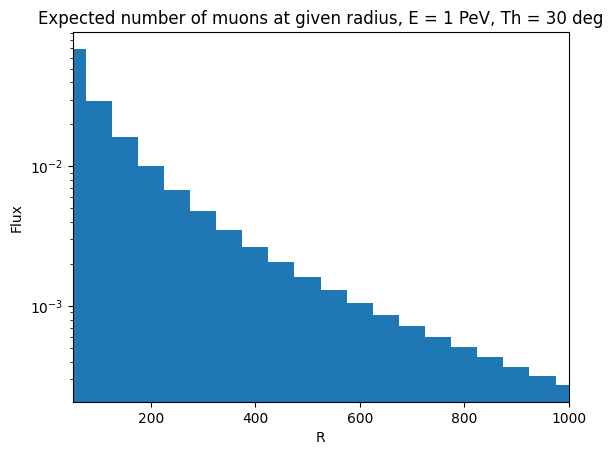

In [15]:
energy = torch.tensor([1.], requires_grad = True)
theta = torch.tensor([np.pi / 6], requires_grad = True)
R = torch.tensor(np.linspace(50, 1000, 20), requires_grad = True)
fluxes = []

for r in R:
    fluxes.append(ShowerContent(energy, theta, r, "mg").item())

plt.bar(R.detach().numpy(), fluxes, width = 50)
plt.yscale('log')
plt.ylabel("Flux")
plt.xlabel("R")
plt.title("Expected number of muons at given radius, E = 1 PeV, Th = 30 deg")
plt.xlim((50, 1000))
plt.show()

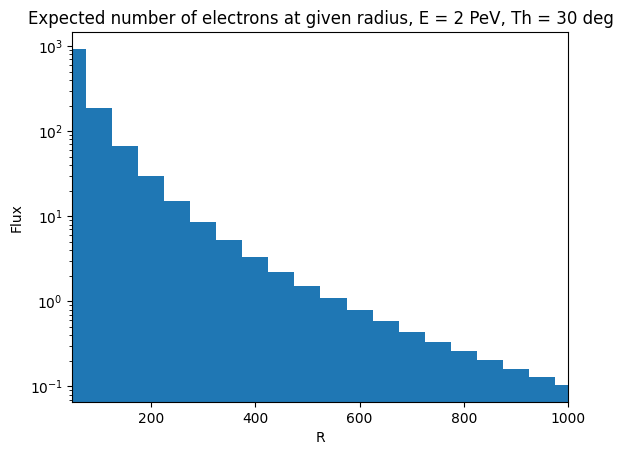

In [16]:
energy = torch.tensor([2.], requires_grad = True)
theta = torch.tensor([np.pi / 6], requires_grad = True)
R = torch.tensor(np.linspace(50, 1000, 20), requires_grad = True)
fluxes = []

for r in R:
    fluxes.append(ShowerContent(energy, theta, r, "eg").item())

plt.bar(R.detach().numpy(), fluxes, width = 50)
plt.yscale('log')
plt.ylabel("Flux")
plt.xlabel("R")
plt.title("Expected number of electrons at given radius, E = 2 PeV, Th = 30 deg")
plt.xlim((50, 1000))
plt.show()

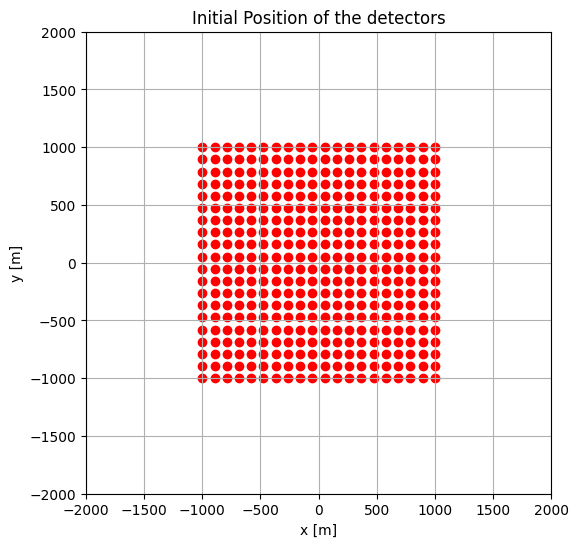

In [17]:
x, y = Layouts()

#Plot the initial positions
plt.figure(figsize = [6, 6])
plt.scatter(x, y, color = "red")
plt.grid()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Initial Position of the detectors")
plt.xlim((-2000, 2000))
plt.ylim((-2000, 2000))
plt.show()

In [18]:
N, T, x0, y0, E, th, ph = GenerateShowers()

Energy = 7.284 PeV
Angle = 24.1 degree


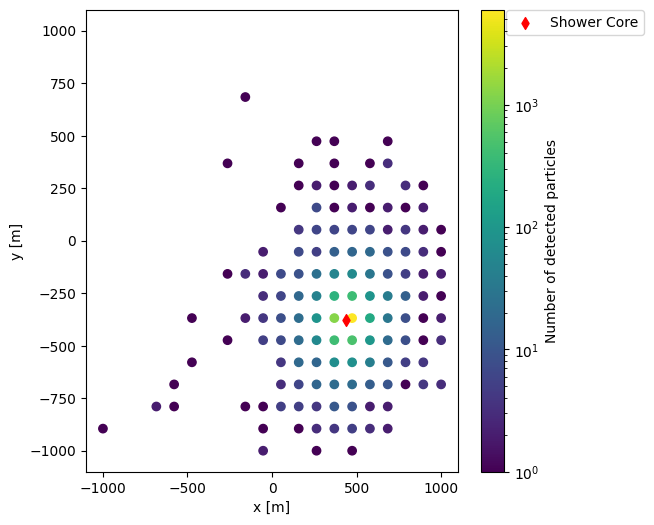

In [19]:
print(f"Energy = {E.item():.3f} PeV")
print(f"Angle = {th.item() * 180 / np.pi:.1f} degree")

norm = LogNorm(vmin = 1, vmax = np.max(N))
plt.figure(figsize = [6, 6])
scatter = plt.scatter(x, y, c = N, cmap = "viridis", norm = norm)
plt.colorbar(scatter, label='Number of detected particles')
plt.scatter(x0.item(), y0.item(), c = "red", marker = "d", label = "Shower Core")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1), borderaxespad=0.)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim((-1100, 1100))
plt.ylim((-1100, 1100))
plt.show()

Angle = 24.1 degree
Phi = -98.5 degree


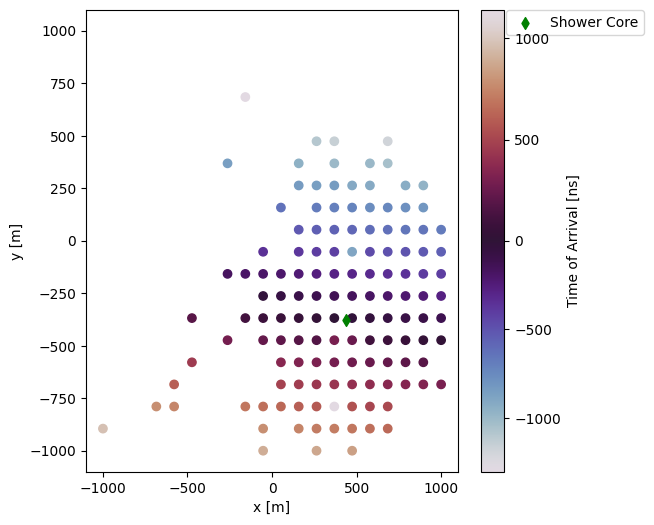

In [20]:
print(f"Angle = {th.item() * 180 / np.pi:.1f} degree")
print(f"Phi = {ph.item() * 180 / np.pi:.1f} degree")

norm = TwoSlopeNorm(vmin=np.min(T), vcenter=0, vmax=np.max(T))

idx = np.where(N > 0)
plt.figure(figsize = [6, 6])
scatter = plt.scatter(x[idx], y[idx], c = T[idx], cmap = "twilight", norm = norm)
plt.colorbar(scatter, label='Time of Arrival [ns]')
plt.scatter(x0.item(), y0.item(), c = "green", marker = "d", label = "Shower Core")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1), borderaxespad=0.)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim((-1100, 1100))
plt.ylim((-1100, 1100))
plt.show()

## Training the Network

We first need some simulations to train our neural network. In the global variables part, you will find a variable num_events, which is set to 10000. We will use this number to generate random events.

In [120]:
%%time

inputs = torch.zeros((Nevents, 400, 4))
labels = torch.zeros((Nevents, 5))

for i in range(100):
    N, T, x0, y0, E, theta, phi = GenerateShowers()

    input_vector = np.column_stack((x, y, N, T))

    inputs[i] = torch.tensor(input_vector, dtype = torch.float32)
    labels[i] = torch.tensor([x0 / 1000, y0 / 1000, E, theta, phi], dtype = torch.float32)
    #We are writing X0 and Y0 in units of km, otherwise the scales for inputs differ too much that it could cause a confusion
    #in our NN

    if (i + 1) % 10 == 0:
        print(f"Shower generation is {(i + 1)}% done")


#We also need to normalize our inputs, otherwise it will cause a problem in NN training

x_train_np = inputs.reshape(-1, inputs.shape[-1]).numpy()

scaler = StandardScaler()
x_train_scaled_np = scaler.fit_transform(x_train_np)

# Reshape back to original shape
inputs = torch.tensor(x_train_scaled_np).reshape(inputs.shape)

Shower generation is 10% done
Shower generation is 20% done
Shower generation is 30% done
Shower generation is 40% done
Shower generation is 50% done
Shower generation is 60% done
Shower generation is 70% done
Shower generation is 80% done
Shower generation is 90% done
Shower generation is 100% done
CPU times: user 2min 30s, sys: 2.2 s, total: 2min 32s
Wall time: 2min 35s


In [127]:
#In this part we are defining our model, which is the Neural network for our reconstruction
#We will use Mean Square Error Loss
#Optimization model is SGD, to keep consistent with our next steps
model = Reconstruction()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = .005)

In [128]:
%%time

for num_epoch in range(Nepochs):
    for i in range(Nevents):
        train_x = inputs[i]
        train_x = train_x.view(1, -1) #Flatten the input
        
        train_y = labels[i].view(1, 5)
        
        #Train the network
        outputs = model(train_x)

        loss = criterion(outputs, train_y)

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

    if (num_epoch + 1) % 100 == 0:
        print(f"Training is {int((num_epoch + 1) * 100 / 1000)}% done")

Training is 10% done
Training is 20% done
Training is 30% done
Training is 40% done
Training is 50% done
Training is 60% done
Training is 70% done
Training is 80% done
Training is 90% done
Training is 100% done
CPU times: user 6min 22s, sys: 8.24 s, total: 6min 30s
Wall time: 1min 43s


In [129]:
N, T, x0, y0, E, th, ph = GenerateShowers()
X = torch.tensor(np.column_stack((x, y, N, T)), dtype = torch.float32)

scale = X.reshape(-1, X.shape[-1]).numpy()

scaler = StandardScaler()
scaled = scaler.fit_transform(scale)

# Reshape back to original shape
X = torch.tensor(scaled).reshape(X.shape)

output = model(X)

real = torch.tensor([x0 / 1000, y0 / 1000, E, th, ph], dtype = torch.float32)

print("Predicted X, Y, E, Th, Phi:", output)
print("Real X, Y, E, Th, Phi:", real)

Predicted X, Y, E, Th, Phi: tensor([[-0.1271, -0.1704,  0.6222,  0.3642, -1.1866]],
       grad_fn=<AddmmBackward0>)
Real X, Y, E, Th, Phi: tensor([-0.2348, -0.8253,  0.8457,  0.9013,  2.1853])


In [130]:
N, T, x0, y0, E, th, ph = GenerateShowers()
X = torch.tensor(np.column_stack((x, y, N, T)), dtype = torch.float32)

scale = X.reshape(-1, X.shape[-1]).numpy()

scaler = StandardScaler()
scaled = scaler.fit_transform(scale)

# Reshape back to original shape
X = torch.tensor(scaled).reshape(X.shape)

output = model(X)

real = torch.tensor([x0 / 1000, y0 / 1000, E, th, ph], dtype = torch.float32)

print("Predicted X, Y, E, Th, Phi:", output)
print("Real X, Y, E, Th, Phi:", real)

Predicted X, Y, E, Th, Phi: tensor([[ 0.0117, -0.0088,  4.7841,  0.5604,  0.1788]],
       grad_fn=<AddmmBackward0>)
Real X, Y, E, Th, Phi: tensor([-0.4854, -0.5127,  5.2377,  0.3762, -3.1405])
